# Caso de validacion, pozo unidimensional

# PINN para el pozo infinito 1D

En este notebook se implementara una **PINN (Physics-Informed Neural Network)** para resolver la ecuación de Schrödinger en un **pozo de potencial infinito unidimensional** en el intervalo \([0,1]\).

El objetivo de **validación** es fijar las energías conocidas analíticamente y comprobar que la PINN puede reconstruir las funciones de onda correspondientes.

---

## 1) Planteamiento físico

La ecuación de Schrödinger independiente del tiempo en una dimensión es:

$$
\psi''(x) + \big(E - V(x)\big)\,\psi(x) = 0, \quad x \in (0,1),
$$

con condiciones de frontera de tipo Dirichlet:

$$
\psi(0)=0, \qquad \psi(1)=0.
$$

Para el **pozo infinito** se tiene:

$$
V(x)=0 \quad (0<x<1), \qquad V(x)=\infty \quad (x\leq 0, x \geq 1).
$$

Las soluciones analíticas son:

- **Funciones de onda:**
$$
\psi_n(x) = \sqrt{2}\,\sin(n\pi x), \qquad n=1,2,3,\dots
$$

- **Energías:**
$$
E_n = (n\pi)^2.
$$

En este caso de validación, **no se entrena la energía**, sino que se fija en el valor conocido \(E_n\). La PINN solo debe aprender la forma de $$
\psi_n(x) = \sqrt{2}\,\sin(n\pi x)
$$

![Figura](img.png)




---

In [4]:

import os, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.keras.utils.set_random_seed(0)


## 2) Trial con estructura física

Usamos un *trial function* que incorpora de antemano las condiciones de frontera y los nodos interiores del modo \(n\):

$$
\psi(x) \;=\; x(1-x)\,\frac{\sin(n\pi x)}{\sin(\pi x)}\,N_\theta(x).
$$

- El factor $x(1-x)$ asegura que $\psi(0)=\psi(1)=0$.
- El factor trigonométrico $F_n(x)=\dfrac{\sin(n\pi x)}{\sin(\pi x)}$ fuerza los nodos en $x=\tfrac{k}{n}$.
- $N_\theta(x)$ es la red neuronal que ajusta la forma y la amplitud.


De esta manera la red queda **guiada físicamente** hacia el modo \(n\) correcto y evitamos que colapse al fundamental.

---

In [5]:
def trig_nodal_factor(x, n):
    s1 = tf.sin(math.pi * x)
    sn = tf.sin(n * math.pi * x)
    ratio = sn / (s1 + 1e-12)
    # en extremos, límite F_n = n
    return tf.where(tf.abs(s1) < 1e-6, tf.cast(n, x.dtype), ratio)

def make_net(n=1, hidden=64, use_sine=True):
    x_in = tf.keras.Input(shape=(1,))
    if use_sine:
        z = tf.keras.layers.Dense(hidden, activation=tf.math.sin,
                                  kernel_initializer="glorot_uniform",
                                  bias_initializer="zeros")(x_in)
        z = tf.keras.layers.Dense(hidden, activation=tf.math.sin,
                                  kernel_initializer="glorot_uniform",
                                  bias_initializer="zeros")(z)
    else:
        z = tf.keras.layers.Dense(hidden, activation="tanh",
                                  kernel_initializer="glorot_uniform",
                                  bias_initializer="zeros")(x_in)
        z = tf.keras.layers.Dense(hidden, activation="tanh",
                                  kernel_initializer="glorot_uniform",
                                  bias_initializer="zeros")(z)
    out = tf.keras.layers.Dense(1, activation=None,
                                kernel_initializer="glorot_uniform",
                                bias_initializer="zeros")(z)
    F = trig_nodal_factor(x_in, n)
    psi = x_in * (1.0 - x_in) * F * out
    return tf.keras.Model(inputs=x_in, outputs=psi)

## 3) Derivadas con autodiferenciación

Para evaluar el residual de la ecuación de Schrödinger necesitamos $(\psi''(x))$.

Esto se calcula con **`GradientTape` anidado de TensorFlow**, que permite obtener la primera y la segunda derivada automáticamente.

---

In [6]:
def second_derivative(model, x):
    x = tf.convert_to_tensor(x); x = tf.reshape(x, (-1,1))
    with tf.GradientTape(persistent=True) as t2:
        t2.watch(x)
        with tf.GradientTape() as t1:
            t1.watch(x)
            psi = model(x)
        psi_x = t1.gradient(psi, x)
    psi_xx = t2.gradient(psi_x, x)
    return psi, psi_xx

## 4) Función de pérdida

La pérdida total combina dos términos:

$$
\mathcal{L} \;=\; L_{\text{PDE}} + \lambda\,L_{\text{norm}},
$$

donde:

- Residual del PDE:
$$
L_{\text{PDE}} = \mathbb{E}\big[(\psi''(x)+E\psi(x))^2\big].
$$

- Normalización:
$$
L_{\text{norm}} = \left(\int_0^1 |\psi(x)|^2 dx - 1\right)^2.
$$

- $(\lambda)$ es un peso dinámico que se usa con **warm-up**:
  - Grande al inicio para evitar la solución trivial $(\psi \approx 0)$.
  - Más pequeño después para balancear PDE y normalización.

---

In [7]:
@tf.function
def compute_losses(net, x_batch, E, lam):
    psi, psi_xx = second_derivative(net, x_batch)
    res = psi_xx + E * psi                         # V=0
    LPDE = tf.reduce_mean(tf.square(res))
    psi2 = tf.squeeze(tf.square(psi), axis=1)
    xb = tf.squeeze(tf.convert_to_tensor(x_batch), axis=1)
    dx = xb[1:] - xb[:-1]
    integral = tf.reduce_sum(0.5*(psi2[1:]+psi2[:-1])*dx)
    Lnorm = tf.square(integral - 1.0)
    L = LPDE + lam * Lnorm
    return L, LPDE, Lnorm, integral

## 5) Entrenamiento de un modo

Para cada modo $n$:

1. Fijamos la energía exacta $E = (n\pi)^2$.
2. Construimos la red y el *trial* con el enforcer trigonométrico.
3. Muestreamos puntos de colación $x$.
4. Optimizamos con **Adam**, *learning-rate decay* y *gradient clipping*.
5. Usamos *warm-up* de normalización en el primer tercio de las épocas.
6. Al finalizar, alineamos el signo global de la PINN con la exacta y calculamos métricas:
   - Error $L_2$.
   - Integral de normalización $\int_0^1 |\psi(x)|^2\,dx$.

Se guarda una figura comparando **PINN vs exacta** para ese modo.


In [8]:
def run_one_mode(n, save_dir="resultados"):
    os.makedirs(save_dir, exist_ok=True)

    # energía y hiperparámetros (heurística según n)
    E = np.float32((n * math.pi)**2)
    USE_SINE = True if n >= 3 else False
    HIDDEN   = 128 if n >= 3 else 64
    N_col    = max(1024, 2048*n)
    EPOCHS   = 15000 if n >= 4 else (9000 if n==3 else (6000 if n==2 else 4000))
    LR0      = 3e-4  if n >= 4 else (5e-4 if n==3 else (7e-4 if n==2 else 1e-3))

    lam_hi, lam_lo = (300.0, 80.0) if n >= 3 else (40.0, 15.0 if n==2 else 10.0)

    # red y colación
    net = make_net(n=n, hidden=HIDDEN, use_sine=USE_SINE)
    x_col = np.linspace(0,1,N_col, dtype=np.float32).reshape(-1,1)
    x_batch = tf.constant(x_col)

    # optimizador con decay + clipping
    lr_sched = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=LR0, decay_steps=EPOCHS, end_learning_rate=LR0*0.1, power=1.0
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_sched, clipnorm=1.0)

    # listas para registrar pérdidas
    loss_total, loss_pde, loss_norm = [], [], []

    # entrenamiento
    for ep in range(1, EPOCHS+1):
        lam = lam_hi if ep < EPOCHS//3 else lam_lo
        with tf.GradientTape() as tape:
            L, LPDE, Lnorm, integral = compute_losses(net, x_batch, E, lam)
        grads = tape.gradient(L, net.trainable_variables)
        opt.apply_gradients(zip(grads, net.trainable_variables))

        # guardar historial
        loss_total.append(float(L))
        loss_pde.append(float(LPDE))
        loss_norm.append(float(Lnorm))

        if ep % max(800, EPOCHS//6) == 0 or ep == 1:
            tf.print(f"n={n}", "ep", ep, "| LPDE=", LPDE, " Lnorm=", Lnorm,
                     " L=", L, " ∫|ψ|²≈", integral, " λ=", lam)

    # --- curva de pérdida ---
    plt.figure(figsize=(7,5))
    plt.semilogy(loss_total, label="Total Loss")
    plt.semilogy(loss_pde, label=r"$\mathcal{L}_{PDE}$")
    plt.semilogy(loss_norm, label=r"$\mathcal{L}_{norm}$")
    plt.xlabel("Épocas")
    plt.ylabel("Valor de la pérdida")
    plt.title(f"Curva de pérdida (n={n})")
    plt.legend()
    out_path_loss = os.path.join(save_dir, f"loss_{n}.png")
    plt.savefig(out_path_loss, dpi=150, bbox_inches="tight"); plt.close()

    # evaluación fina
    xs = np.linspace(0,1,2000, dtype=np.float32).reshape(-1,1)
    psi_pred = net(xs).numpy().squeeze()
    psi_exact = (np.sqrt(2.0)*np.sin(n*math.pi*xs)).squeeze()

    # alinear signo
    sign = np.sign(np.dot(psi_pred, psi_exact)); psi_pred *= sign

    # métricas
    l2_err = float(np.sqrt(np.mean((psi_pred-psi_exact)**2)))
    integ  = float(np.trapz(psi_pred**2, xs.squeeze()))

    # figura por modo (PINN vs exacta)
    plt.figure()
    plt.plot(xs.squeeze(), psi_pred, label=f"PINN ψ_{n}")
    plt.plot(xs.squeeze(), psi_exact, "--", label=f"Exacta ψ_{n}")
    plt.title(f"Modo n={n}  |  E={(n*math.pi)**2:.2f}  |  L2={l2_err:.2e}")
    plt.xlabel("x"); plt.ylabel("ψ"); plt.legend()
    out_path = os.path.join(save_dir, f"modo_{n}.png")
    plt.savefig(out_path, dpi=150, bbox_inches="tight"); plt.close()

    return dict(n=n, xs=xs.squeeze(), psi_pred=psi_pred,
                psi_exact=psi_exact, E=float(E), L2=l2_err, integral=integ,
                fig_path=out_path, loss_path=out_path_loss,
                losses=loss_total, losses_pde=loss_pde, losses_norm=loss_norm)


## Loop de modos y guardado

Entrenamos automáticamente los modos $n=1,\dots,n_{\max}$ en un **loop**,
guardamos cada figura `modo_n.png` y almacenamos resultados en `all_results`.


In [9]:
# ========= loop principal: elige hasta qué n quieres =========
n_max = 6   # <--- CAMBIA SOLO ESTO
all_results = []
for n in range(1, n_max+1):
    res = run_one_mode(n, save_dir="resultados")
    print(f"[OK] n={n}  L2={res['L2']:.2e}  ∫|ψ|²≈{res['integral']:.3f}  fig={res['fig_path']}")
    all_results.append(res)

n=1 ep 1 | LPDE= 0.021139415  Lnorm= 0.999828696  L= 40.0142899  ∫|ψ|²≈ 8.56222177e-05  λ= 40.0
n=1 ep 800 | LPDE= 0.00192922715  Lnorm= 3.10587112e-09  L= 0.00192935136  ∫|ψ|²≈ 0.99994427  λ= 40.0
n=1 ep 1600 | LPDE= 0.00126986357  Lnorm= 1.24234845e-08  L= 0.00126998778  ∫|ψ|²≈ 0.999888539  λ= 10.0
n=1 ep 2400 | LPDE= 0.000697618234  Lnorm= 1.52886059e-09  L= 0.000697633543  ∫|ψ|²≈ 0.999960899  λ= 10.0
n=1 ep 3200 | LPDE= 0.000333409291  Lnorm= 6.35683506e-10  L= 0.000333415635  ∫|ψ|²≈ 0.999974787  λ= 10.0
n=1 ep 4000 | LPDE= 0.000173339315  Lnorm= 4.9163873e-10  L= 0.000173344233  ∫|ψ|²≈ 0.999977827  λ= 10.0
[OK] n=1  L2=4.69e-05  ∫|ψ|²≈1.000  fig=resultados\modo_1.png
n=2 ep 1 | LPDE= 1.09081483  Lnorm= 0.996980429  L= 40.9700356  ∫|ψ|²≈ 0.00151093234  λ= 40.0
n=2 ep 1000 | LPDE= 0.00059530919  Lnorm= 7.3420793e-08  L= 0.000598246  ∫|ψ|²≈ 0.999729037  λ= 40.0
n=2 ep 2000 | LPDE= 0.00020559832  Lnorm= 1.28751765e-09  L= 0.000205617631  ∫|ψ|²≈ 1.00003588  λ= 15.0
n=2 ep 3000 | LPDE= 

## Figura resumen

Construimos una figura única con todos los modos:

- PINN (sólida) vs Exacta (punteada gris).
- Cada modo desplazado en el eje $y$ para no solaparse.

In [10]:
# ========= figura apilada con todos =========
plt.figure(figsize=(10,7))
offset = 2.2
for r in all_results:
    y0 = offset*(r['n']-1)
    plt.plot(r['xs'], r['psi_exact'] + y0, "--", color="gray", linewidth=1)
    plt.plot(r['xs'], r['psi_pred'] + y0, label=f"ψ_{r['n']}")
plt.xlabel("x"); plt.ylabel("ψ_n(x) (desplazadas)")
plt.title(f"Pozo infinito — PINN vs exactas para n=1..{n_max}")
plt.legend(ncol=3)
plt.savefig("resultados/modos_apilados.png", dpi=160, bbox_inches="tight")
plt.close()
print("[OK] Figura apilada: resultados/modos_apilados.png")

[OK] Figura apilada: resultados/modos_apilados.png


## Conclusiones generales

- **BCs:** $\psi(0)\approx 0$, $\psi(1)\approx 0$.
- **Nodos:** en $x=k/n$.
- **Normalización:** $\int_0^1|\psi|^2dx \approx 1$.
- **Residual PDE:** pequeño ($10^{-4}\sim10^{-5}$).
- **Error $L_2$:** bajo frente a la solución analítica.

**Conclusión:**
En este caso de validación se fija $E=(n\pi)^2$ y la PINN aprende la forma de
$\psi_n(x)=\sqrt{2}\sin(n\pi x)$.
El trial con enforcer trigonométrico y warm-up de normalización permiten recuperar
los modos $n=1,\dots,n_{\max}$ con buena precisión.


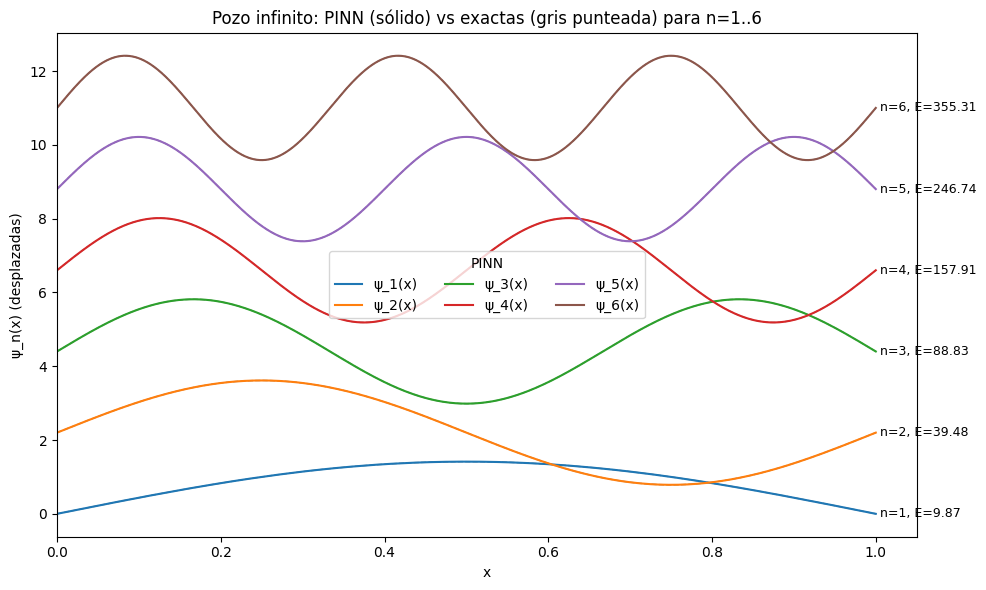

In [20]:
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(10,6))
offset = 2.2  # separa visualmente cada modo

for res in all_results:
    n = res['n']
    yoff = offset*(n-1)

    # (por si no lo hiciste antes) alinear signo de la PINN con la exacta
    sign = np.sign(np.dot(res['psi_pred'], res['psi_exact']))
    psi_p = res['psi_pred'] * sign
    psi_e = res['psi_exact']

    # exacta: gris punteada
    plt.plot(res['xs'], psi_e + yoff, "--", color="gray", linewidth=1)

    # PINN: línea sólida de color
    plt.plot(res['xs'], psi_p + yoff, label=f"ψ_{n}(x)")

    # etiqueta a la derecha con energía
    En = (n*math.pi)**2
    plt.text(1.005, (psi_e[-1] + yoff), f"n={n}, E={En:.2f}",
             va="center", fontsize=9, transform=plt.gca().transData)

plt.xlabel("x")
plt.ylabel("ψ_n(x) (desplazadas)")
plt.title("Pozo infinito: PINN (sólido) vs exactas (gris punteada) para n=1..6")
plt.legend(ncol=3, title="PINN")
plt.xlim(0, 1.05)  # deja espacio a la derecha para las etiquetas
plt.tight_layout()
plt.savefig("resultados/pinn_vs_exactas_todos.png", dpi=180)
plt.show()


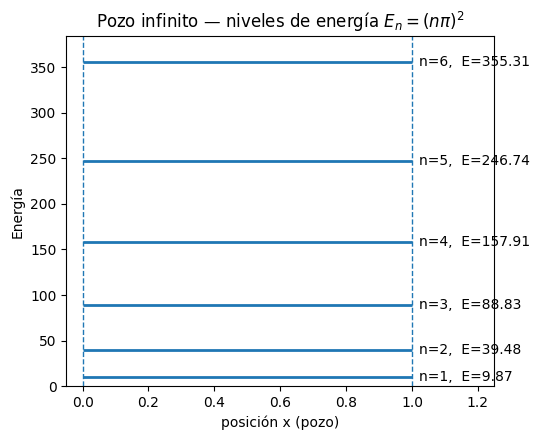

In [12]:
import math
import matplotlib.pyplot as plt

N = 6  # cuántos estados mostrar
E = [(n*math.pi)**2 for n in range(1, N+1)]

plt.figure(figsize=(5.5, 4.5))
for n, En in enumerate(E, start=1):
    # línea horizontal para el nivel de energía En
    plt.hlines(En, 0.0, 1.0, linewidth=2)
    # etiqueta a la derecha
    plt.text(1.02, En, f"n={n},  E={(En):.2f}", va='center')

# “paredes” del pozo para referencia visual
plt.vlines([0.0, 1.0], 0, E[-1]*1.08, linestyles='--', linewidth=1)

plt.xlim(-0.05, 1.25)
plt.ylim(0, E[-1]*1.08)
plt.xlabel("posición x (pozo)")
plt.ylabel("Energía")
plt.title("Pozo infinito — niveles de energía $E_n=(n\\pi)^2$")
plt.tight_layout()
plt.show()


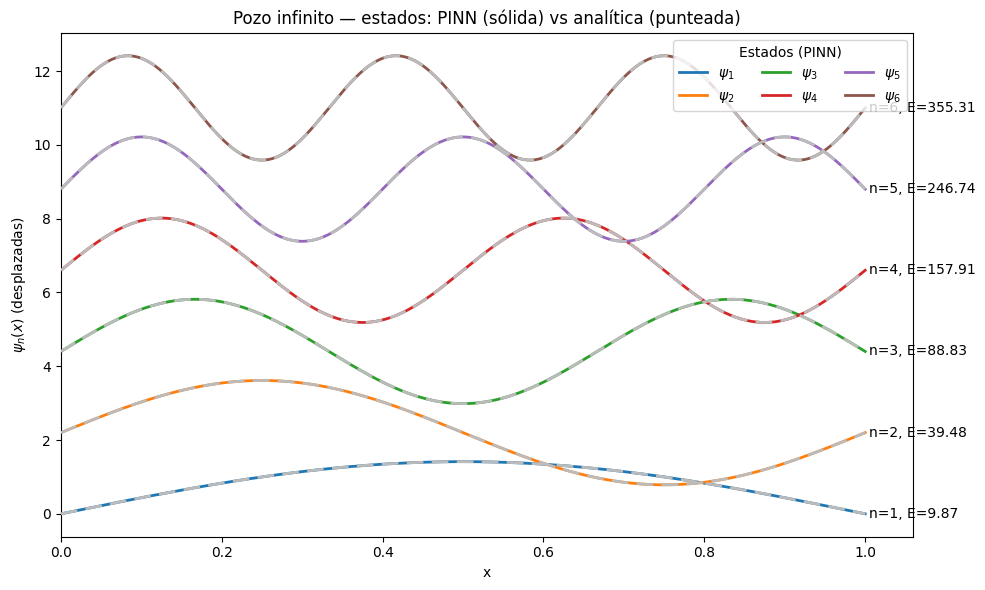

In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os

assert 'all_results' in globals(), "No encuentro all_results: corre el loop de entrenamiento primero."

# Crear carpeta "resultados" si no existe
os.makedirs("resultados", exist_ok=True)

plt.figure(figsize=(10, 6))
offset = 2.2

for r in all_results:
    n = r['n']
    xs = r['xs']
    psi_p = r['psi_pred'].copy()
    psi_e = r['psi_exact'].copy()

    # Alinear signo por si acaso
    sgn = np.sign(np.dot(psi_p, psi_e))
    psi_p *= sgn

    y0 = offset*(n-1)

    # Analítica punteada (gris claro)
    plt.plot(xs, psi_e + y0, linestyle=(0,(6,3)), color="#BBBBBB",
             linewidth=2.0, zorder=3)

    # PINN sólida
    plt.plot(xs, psi_p + y0, linewidth=2.0, zorder=2,
             label=f"$\\psi_{{{n}}}$")

    En = (n*math.pi)**2
    plt.text(1.005, y0, f"n={n}, E={En:.2f}", va='center', color="black")

plt.xlabel("x")
plt.ylabel("$\\psi_n(x)$ (desplazadas)")
plt.title("Pozo infinito — estados: PINN (sólida) vs analítica (punteada)")
plt.xlim(0, 1.06)
plt.legend(ncol=3, title="Estados (PINN)")
plt.tight_layout()

# --- Guardar en la carpeta "resultados" ---
plt.savefig("resultados/pozo_infinito.png", dpi=300, facecolor="white", bbox_inches="tight")

plt.show()


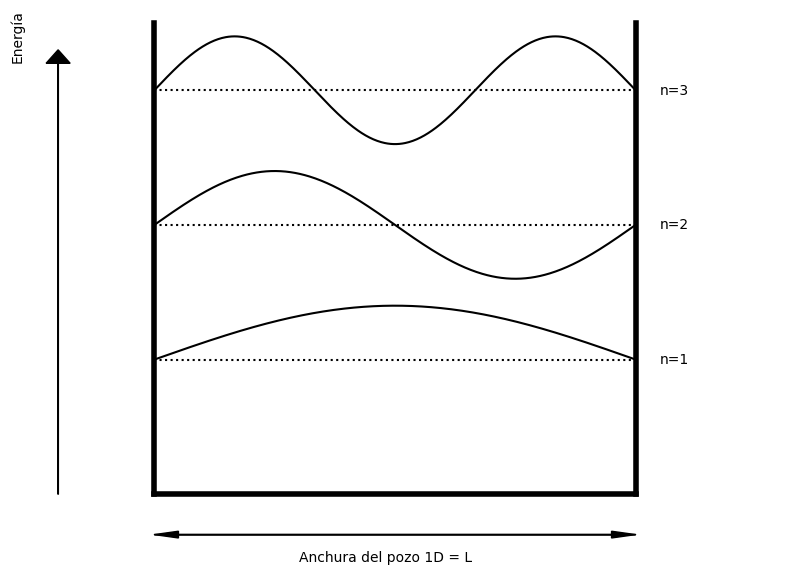

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Rango del pozo (0 a L)
L = 1.0
x = np.linspace(0, L, 500)

# Funciones de onda (no normalizadas, solo ilustrativas)
psi1 = np.sin(np.pi * x / L)
psi2 = np.sin(2 * np.pi * x / L)
psi3 = np.sin(3 * np.pi * x / L)

# Energías relativas (desplazamientos en Y para graficar)
E1, E2, E3 = 1, 2, 3

# Escalamos las funciones para que quepan dentro del pozo
scale = 0.4

plt.figure(figsize=(8,6))

# === Dibujar el pozo (barreras infinitas) ===
plt.plot([0,0], [0,3.5], color="black", linewidth=4)
plt.plot([L,L], [0,3.5], color="black", linewidth=4)
plt.plot([0,L], [0,0], color="black", linewidth=4)

# === Dibujar niveles de energía (líneas punteadas) ===
for E in [E1, E2, E3]:
    plt.hlines(E, 0, L, colors="black", linestyles="dotted")

# === Dibujar funciones de onda "flotando" en cada nivel ===
plt.plot(x, psi1*scale + E1, color="black")
plt.plot(x, psi2*scale + E2, color="black")
plt.plot(x, psi3*scale + E3, color="black")

# === Etiquetas de niveles ===
plt.text(L+0.05, E1, "n=1", va="center")
plt.text(L+0.05, E2, "n=2", va="center")
plt.text(L+0.05, E3, "n=3", va="center")

# === Flecha de Energía (eje Y) ===
plt.arrow(-0.2, 0, 0, 3.3, head_width=0.05, head_length=0.1,
          fc="black", ec="black", length_includes_head=True)
plt.text(-0.3, 3.4, "Energía", rotation=90, va="center")

# === Flecha de anchura del pozo (eje X) ===
plt.arrow(0, -0.3, L, 0, head_width=0.05, head_length=0.05,
          fc="black", ec="black", length_includes_head=True)
plt.arrow(L, -0.3, -L, 0, head_width=0.05, head_length=0.05,
          fc="black", ec="black", length_includes_head=True)
plt.text(L/2-0.2, -0.5, "Anchura del pozo 1D = L")

# Ajustes finales
plt.ylim(-0.6, 3.6)
plt.xlim(-0.3, 1.3)
plt.axis("off")
plt.tight_layout()

# Guardar imagen
plt.savefig("resultados/pozo_infinito_esquema.png", dpi=300, bbox_inches="tight")

plt.show()


In [24]:
net = make_net(n=1, hidden=64, use_sine=False)  # ejemplo con n=1
net.build((None,1))
net.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 tf.math.multiply_35 (TFOpLambd  (None, 1)           0           ['input_8[0][0]']                
 a)                                                                                               
                                                                                                  
 tf.math.sin_14 (TFOpLambda)    (None, 1)            0           ['tf.math.multiply_35[0][0]']    
                                                                                                  
 tf.math.multiply_36 (TFOpLambd  (None, 1)           0           ['input_8[0][0]']          